In [1]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import logging
import multiprocessing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import jax
import jax.numpy as jnp

import arviz as az
import numpyro


from hbmep.config import Config
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)


In [2]:
import numpyro.distributions as dist
from hbmep.model import BaseModel


class MixedEffects(BaseModel):
    LINK = "mixed_effects"

    def __init__(self, config: Config):
        super(MixedEffects, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def fn(self, x, a, b, v, L, ell, H):
        return (
            L
            + jnp.where(
                jnp.less(x, a),
                0.,
                -ell + jnp.true_divide(
                    H + ell,
                    jnp.power(
                        1
                        + jnp.multiply(
                            -1
                            + jnp.power(
                                jnp.true_divide(H + ell, ell),
                                v
                            ),
                            jnp.exp(jnp.multiply(-b, x - a))
                        ),
                        jnp.true_divide(1, v)
                    )
                )
            )
        )

    def _model(self, subject, features, intensity, response_obs=None):
        subject, n_subject = subject
        features, n_features = features
        intensity, n_data = intensity

        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)
        n_feature0 = n_features[0]

        n_baseline = 1
        n_delta = n_feature0 - 1

        """ Fixed Effects (Baseline) """
        with numpyro.plate(site.n_response, self.n_response):
            with numpyro.plate("n_baseline", n_baseline):
                a_fixed_mean = numpyro.sample("a_fixed_mean", dist.TruncatedNormal(5, 10, low=0))
                a_fixed_scale = numpyro.sample("a_fixed_scale", dist.HalfNormal(10.0))

                with numpyro.plate(site.n_subject, n_subject):
                    a_fixed = numpyro.sample(
                        "a_fixed", dist.TruncatedNormal(a_fixed_mean, a_fixed_scale, low=0)
                    )

        """ Random Effects (Delta) """
        with numpyro.plate(site.n_response, self.n_response):
            with numpyro.plate("n_delta", n_delta):
                a_random_mean = numpyro.sample("a_random_mean", dist.Normal(0, 10))
                a_random_scale = numpyro.sample("a_random_scale", dist.HalfNormal(10.0))

                with numpyro.plate(site.n_subject, n_subject):
                    a_random = numpyro.sample("a_random", dist.Normal(a_random_mean, a_random_scale))

                    """ Penalty """
                    penalty_for_negative_a = (jnp.fabs(a_fixed + a_random) - (a_fixed + a_random))
                    numpyro.factor("penalty_for_negative_a", -penalty_for_negative_a)

        with numpyro.plate(site.n_response, self.n_response):
            """ Global Priors """
            b_scale_global_scale = numpyro.sample("b_scale_global_scale", dist.HalfNormal(100))
            v_scale_global_scale = numpyro.sample("v_scale_global_scale", dist.HalfNormal(100))

            L_scale_global_scale = numpyro.sample("L_scale_global_scale", dist.HalfNormal(1))
            ell_scale_global_scale = numpyro.sample("ell_scale_global_scale", dist.HalfNormal(100))
            H_scale_global_scale = numpyro.sample("H_scale_global_scale", dist.HalfNormal(10))

            g_1_scale_global_scale = numpyro.sample("g_1_scale_global_scale", dist.HalfNormal(100))
            g_2_scale_global_scale = numpyro.sample("g_2_scale_global_scale", dist.HalfNormal(100))

            with numpyro.plate("n_feature0", n_feature0):
                """ Hyper-priors """
                b_scale_raw = numpyro.sample("b_scale_raw", dist.HalfNormal(scale=1))
                b_scale = numpyro.deterministic("b_scale", jnp.multiply(b_scale_global_scale, b_scale_raw))

                v_scale_raw = numpyro.sample("v_scale_raw", dist.HalfNormal(scale=1))
                v_scale = numpyro.deterministic("v_scale", jnp.multiply(v_scale_global_scale, v_scale_raw))

                L_scale_raw = numpyro.sample("L_scale_raw", dist.HalfNormal(scale=1))
                L_scale = numpyro.deterministic("L_scale", jnp.multiply(L_scale_global_scale, L_scale_raw))

                ell_scale_raw = numpyro.sample("ell_scale_raw", dist.HalfNormal(scale=1))
                ell_scale = numpyro.deterministic("sigma_ell", jnp.multiply(ell_scale_global_scale, ell_scale_raw))

                H_scale_raw = numpyro.sample("H_scale_raw", dist.HalfNormal(scale=1))
                H_scale = numpyro.deterministic("H_scale", jnp.multiply(H_scale_global_scale, H_scale_raw))

                g_1_scale_raw = numpyro.sample("g_1_scale_raw", dist.HalfNormal(scale=1))
                g_1_scale = numpyro.deterministic("g_1_scale", jnp.multiply(g_1_scale_global_scale, g_1_scale_raw))

                g_2_scale_raw = numpyro.sample("g_2_scale_raw", dist.HalfNormal(scale=1))
                g_2_scale = numpyro.deterministic("g_2_scale", jnp.multiply(g_2_scale_global_scale, g_2_scale_raw))

                with numpyro.plate(site.n_subject, n_subject):
                    """ Priors """
                    a = numpyro.deterministic(
                        site.a,
                        jnp.concatenate([a_fixed, a_fixed + a_random], axis=1)
                    )

                    b_raw = numpyro.sample("b_raw", dist.HalfNormal(scale=1))
                    b = numpyro.deterministic(site.b, jnp.multiply(b_scale, b_raw))

                    v_raw = numpyro.sample("v_raw", dist.HalfNormal(scale=1))
                    v = numpyro.deterministic(site.v, jnp.multiply(v_scale, v_raw))

                    L_raw = numpyro.sample("L_raw", dist.HalfNormal(scale=1))
                    L = numpyro.deterministic(site.L, jnp.multiply(L_scale, L_raw))

                    ell_raw = numpyro.sample("ell_raw", dist.HalfNormal(scale=1))
                    ell = numpyro.deterministic("ell", jnp.multiply(ell_scale, ell_raw))

                    H_raw = numpyro.sample("H_raw", dist.HalfNormal(scale=1))
                    H = numpyro.deterministic(site.H, jnp.multiply(H_scale, H_raw))

                    g_1_raw = numpyro.sample("g_1_raw", dist.HalfCauchy(scale=1))
                    g_1 = numpyro.deterministic(site.g_1, jnp.multiply(g_1_scale, g_1_raw))

                    g_2_raw = numpyro.sample("g_2_raw", dist.HalfCauchy(scale=1))
                    g_2 = numpyro.deterministic(site.g_2, jnp.multiply(g_2_scale, g_2_raw))

        """ Outlier Distribution """
        outlier_prob = numpyro.sample("outlier_prob", dist.Uniform(0., .05))
        outlier_scale = numpyro.sample("outlier_scale", dist.HalfNormal(30))

        with numpyro.plate(site.n_response, self.n_response):
            with numpyro.plate(site.n_data, n_data):
                """ Model """
                mu = numpyro.deterministic(
                    site.mu,
                    self.fn(
                        x=intensity,
                        a=a[subject, feature0],
                        b=b[subject, feature0],
                        v=v[subject, feature0],
                        L=L[subject, feature0],
                        ell=ell[subject, feature0],
                        H=H[subject, feature0]
                    )
                )
                beta = numpyro.deterministic(
                    site.beta,
                    g_1[subject, feature0] + jnp.true_divide(g_2[subject, feature0], mu)
                )

                q = numpyro.deterministic("q", outlier_prob * jnp.ones((n_data, self.n_response)))
                bg_scale = numpyro.deterministic("bg_scale", outlier_scale * jnp.ones((n_data, self.n_response)))

                mixing_distribution = dist.Categorical(
                    probs=jnp.stack([1 - q, q], axis=-1)
                )
                component_distributions=[
                    dist.Gamma(concentration=jnp.multiply(mu, beta), rate=beta),
                    dist.HalfNormal(scale=bg_scale)
                ]

                """ Mixture """
                Mixture = dist.MixtureGeneral(
                    mixing_distribution=mixing_distribution,
                    component_distributions=component_distributions
                )

                """ Observation """
                numpyro.sample(
                    site.obs,
                    Mixture,
                    obs=response_obs
                )

In [3]:
toml_path = "/home/vishu/repos/hbmep-paper/configs/paper/intraoperative/config.toml"

config = Config(toml_path=toml_path)
config.BUILD_DIR = "/home/vishu/repos/hbmep-paper/reports/paper/figures/intraoperative/midline-lateral/all-muscles"
config.RESPONSE = ["Triceps", "APB", "ADM"]

config.MCMC_PARAMS["num_warmup"] = 5000
config.MCMC_PARAMS["num_samples"] = 1000
config.MCMC_PARAMS["num_chains"] = 12

model = MixedEffects(config=config)


2023-11-28 09:26:41,910 - hbmep.config - INFO - Verifying configuration ...
2023-11-28 09:26:41,910 - hbmep.config - INFO - Success!
2023-11-28 09:26:41,926 - hbmep.model.baseline - INFO - Initialized base_model


In [4]:
src = "/home/vishu/data/hbmep-processed/human/intraoperative/data.csv"
df = pd.read_csv(src)

df[model.features[0]] = df[model.features[0]].replace({"L": "01_L", "M": "02_M"})

ind = ~df[model.response].isna().values.any(axis=-1)
df = df[ind].reset_index(drop=True).copy()

df, encoder_dict = model.load(df=df)


2023-11-28 09:26:41,983 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/paper/figures/intraoperative/midline-lateral/all-muscles
2023-11-28 09:26:41,983 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/paper/figures/intraoperative/midline-lateral/all-muscles
2023-11-28 09:26:41,984 - hbmep.dataset.core - INFO - Processing data ...
2023-11-28 09:26:41,985 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [5]:
src = "/home/vishu/repos/hbmep-paper/reports/paper/intraoperative/midline-lateral/all-muscles/inference.pkl"

with open(src, "rb") as g:
    _, mcmc, posterior_samples = pickle.load(g)


In [6]:
_posterior_samples = posterior_samples.copy()
_posterior_samples["outlier_prob"] = _posterior_samples["outlier_prob"] * 0

prediction_df = model.make_prediction_dataset(df=df, num=100)
posterior_predictive = model.predict(df=prediction_df, posterior_samples=_posterior_samples)

# model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=_posterior_samples, prediction_df=prediction_df, posterior_predictive=posterior_predictive)
# model.render_predictive_check(df=df, encoder_dict=encoder_dict, prediction_df=prediction_df, posterior_predictive=posterior_predictive)


2023-11-28 09:26:43,665 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2023-11-28 09:27:21,434 - hbmep.utils.utils - INFO - func:predict took: 37.77 sec


In [7]:
from numpyro.diagnostics import hpdi

a = posterior_samples[site.a]
a.shape

a_map = a.mean(axis=0)
a_map.shape

mu = posterior_predictive[site.mu]
obs = posterior_predictive[site.obs]

obs_hpdi = hpdi(obs, prob=.95)
obs_hpdi.shape

a_random_mean = posterior_samples["a_random_mean"]
a_random_mean.shape

response_colors = {
    0: {
        0: (0.6706, 0.8510, 0.9137),
        1: (0.9451, 0.7137, 0.8549),
        2: (0.7216, 0.8824, 0.5255)
    },
    1: {
        0: (0.1725, 0.4824, 0.7137),
        1: (0.8157, 0.1098, 0.5451),
        2: (0.3020, 0.6745, 0.1490)
    }
}


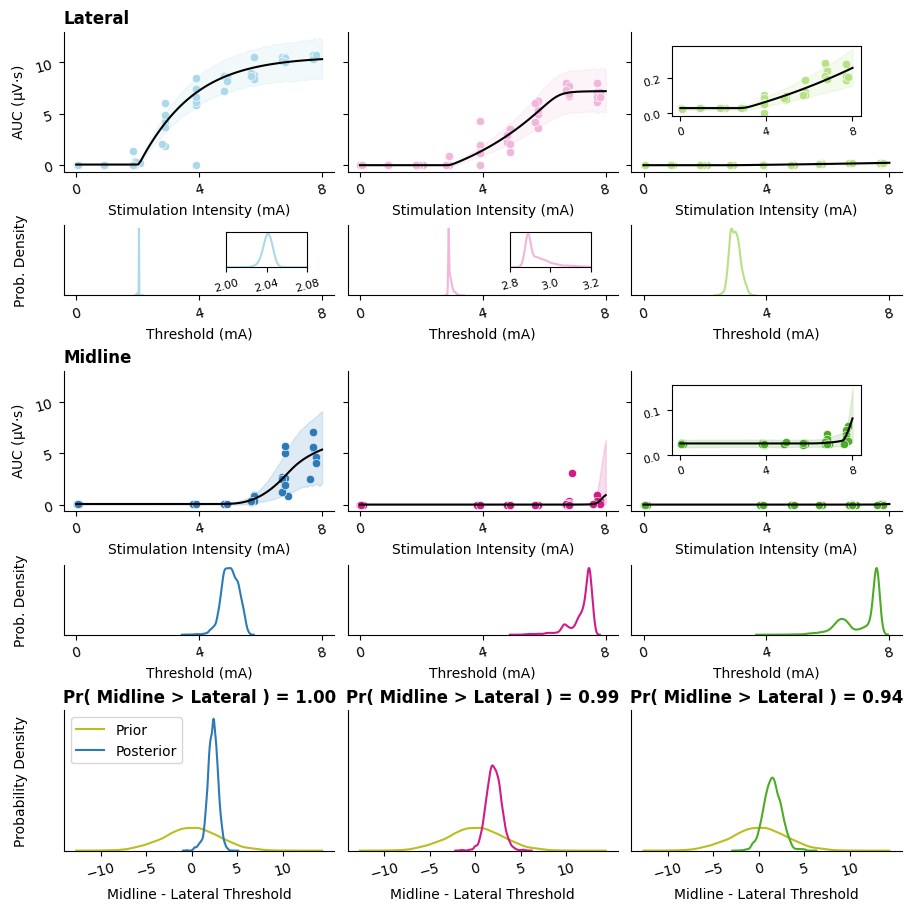

In [67]:
cmap = sns.color_palette("tab10")
axis_label_size = 10

nrows, ncols = 5, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 1.8 * nrows), squeeze=False, height_ratios=[1, .5, 1, .5, 1], constrained_layout=True)

# for i in range(nrows):
#     for j in range(ncols):
#         axes[i, j].set_visible(False)

for muscle_ind in range(model.n_response):
    for side in [0, 1]:
        c = (7, side)
        color = response_colors[side][muscle_ind]

        ind = df[model.combination_columns[::-1]].apply(tuple, axis=1).isin([c])
        temp_df = df[ind].reset_index(drop=True).copy()

        pred_ind = prediction_df[model.combination_columns[::-1]].apply(tuple, axis=1).isin([c])
        temp_pred_df = prediction_df[pred_ind].reset_index(drop=True).copy()

        temp_obs = obs[:, pred_ind, muscle_ind]
        temp_mu = mu[:, pred_ind, muscle_ind]
        temp_obs_hpdi = obs_hpdi[:, pred_ind, muscle_ind]

        ax = axes[2 * side, muscle_ind]
        sns.scatterplot(x=temp_df[model.intensity], y=temp_df[model.response[muscle_ind]], ax=ax, color=color)
        # sns.lineplot(x=temp_pred_df[model.intensity], y=temp_obs.mean(axis=0), ax=ax)
        sns.lineplot(x=temp_pred_df[model.intensity], y=temp_mu.mean(axis=0), color="k", ax=ax)
        ax.fill_between(
            temp_pred_df[model.intensity],
            temp_obs_hpdi[0, :],
            temp_obs_hpdi[1, :],
            color=color,
            alpha=.15
        )
        ax.sharex(axes[0, 0])
        ax.sharey(axes[0, 0])

        if (2 * side, muscle_ind) in [(0, 2), (2, 2)]:
            ins = ax.inset_axes([0.15,0.4,0.7,0.5])
            sns.scatterplot(x=temp_df[model.intensity], y=temp_df[model.response[muscle_ind]], ax=ins, color=color)
            sns.lineplot(x=temp_pred_df[model.intensity], y=temp_mu.mean(axis=0), color="k", ax=ins)
            ins.fill_between(
                temp_pred_df[model.intensity],
                temp_obs_hpdi[0, :],
                temp_obs_hpdi[1, :],
                color=color,
                alpha=.15
            )

            ins.set_xlabel("")
            ins.set_ylabel("")
            ins.set_xticks([0, 4, 8])

            if (2 * side, muscle_ind) == (0, 2):
                ins.set_yticks([0, 0.2])
            if (2 * side, muscle_ind) == (2, 2):
                ins.set_yticks([0, 0.1])

            ins.tick_params(
                axis='both',
                which='both',
                left=True,
                bottom=True,
                right=False,
                top=False,
                labelleft=True,
                labelbottom=True,
                labelright=False,
                labeltop=False,
                labelrotation=15,
                labelsize=8
            )

        ax = axes[2 * side + 1, muscle_ind]
        sns.kdeplot(a[:, *c, muscle_ind], ax=ax, color=color)
        ax.sharex(axes[0, 0])

        if (2 * side + 1, muscle_ind) in [(1, 0), (1, 1)]:
            ins = ax.inset_axes([0.6,0.4,0.3,0.5])
            sns.kdeplot(a[:, *c, muscle_ind], ax=ins, color=color)
            ins.set_xlabel("")
            ins.set_ylabel("")
            if (2 * side + 1, muscle_ind) == (1, 0):
                ins.set_xlim(left=2, right=2.08)
                ins.set_xticks([2., 2.04, 2.08])
            if (2 * side + 1, muscle_ind) == (1, 1):
                ins.set_xlim(left=2.8, right=3.2)
                ins.set_xticks([2.8, 3., 3.2])
            # ins.xaxis.set_major_locator(plt.MaxNLocator(2))
            ins.tick_params(
                axis='both',
                which='both',
                left=False,
                bottom=True,
                right=False,
                top=False,
                labelleft=False,
                labelbottom=True,
                labelright=False,
                labeltop=False,
                labelrotation=15,
                labelsize=8
            )

    ax = axes[4, muscle_ind]
    samples = a_random_mean[:, 0, muscle_ind]
    d = dist.Normal(0, 3)
    prior = d.sample(model.rng_key, (10000, ))
    sns.kdeplot(prior, ax=ax, color=cmap[-2], label="Prior")
    sns.kdeplot(samples, ax=ax, color=response_colors[1][muscle_ind], label="Posterior")
    prob = (samples > 0).mean()
    ax.set_title(f"Pr( Midline > Lateral ) = {prob:.2f}", fontweight="bold")
    ax.sharex(axes[4, 0])
    ax.sharey(axes[4, 0])

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        sides = ['right', 'top']
        for side in sides:
            ax.spines[side].set_visible(False)
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=False,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15
        )
        ax.set_xlabel("")
        ax.set_ylabel("")

for muscle_ind in range(model.n_response):
    for side in [0, 1]:
        ax = axes[2 * side, muscle_ind]
        ax.set_xlabel("Stimulation Intensity (mA)", size=axis_label_size)

        ax = axes[2 * side + 1, muscle_ind]
        ax.set_xlabel("Threshold (mA)", size=axis_label_size)
        ax.tick_params(
            axis='both',
            which='both',
            left=False,
            labelleft=False,
            labelrotation=15
        )

        ax = axes[4, muscle_ind]
        ax.set_xlabel("Midline - Lateral Threshold", size=axis_label_size)
        ax.tick_params(
            axis='both',
            which='both',
            left=False,
            labelleft=False,
            labelrotation=15
        )

for ax in [axes[0, 0], axes[2, 0]]:
    ax.tick_params(
        axis='both',
        which='both',
        labelleft=True,
        labelrotation=15
    )
    ax.set_ylabel("AUC (µV$\cdot$s)", size=axis_label_size)

ax = axes[0, 0]
ax.set_yticks([0, 5, 10])
ax.set_xticks([0, 4, 8])

for ax in [axes[1, 0], axes[3, 0]]:
    ax.set_ylabel("Prob. Density", size=axis_label_size)

ax = axes[4, 0]
ax.tick_params(
    axis='both',
    which='both',
    left=True,
    labelleft=True,
    labelbottom=True,
    labelrotation=15
)
ax.tick_params(
    axis='both',
    which='both',
    left=False,
    labelleft=False,
    labelbottom=True,
    labelrotation=15
)
ax.set_ylabel("Probability Density", size=axis_label_size)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([0., 0.4, 0.8])
ax.legend(loc="upper left")

axes[0, 0].set_title("Lateral", fontweight="bold", loc="left")
axes[2, 0].set_title("Midline", fontweight="bold", loc="left")
# axes[4, 0].set_title("Result", fontweight="bold", loc="left")


# """ Insets """
# ax = axes[2, 2]
# ins = ax.inset_axes([0.6,0.4,0.3,0.5])
# sns.kdeplot(a[:, *c, 0], ax=ins, color=response_colors[j])
# ins.set_xlabel("")
# ins.set_ylabel("")
# ins.set_xlim(left=1.98, right=2.1)
# ins.set_ylim(bottom=-.03)



fig.align_xlabels()
fig.align_ylabels()
# [subfig.align_ylabels() for subfig in subfigs]

dest = os.path.join(model.build_dir, "midline-lateral-all-muscles.svg")
fig.savefig(dest, dpi=600)

dest = os.path.join(model.build_dir, "midline-lateral-all-muscles.png")
fig.savefig(dest, dpi=600)


In [9]:
dest

'/home/vishu/repos/hbmep-paper/reports/paper/figures/intraoperative/midline-lateral/all-muscles/midline-lateral-all-muscles.png'

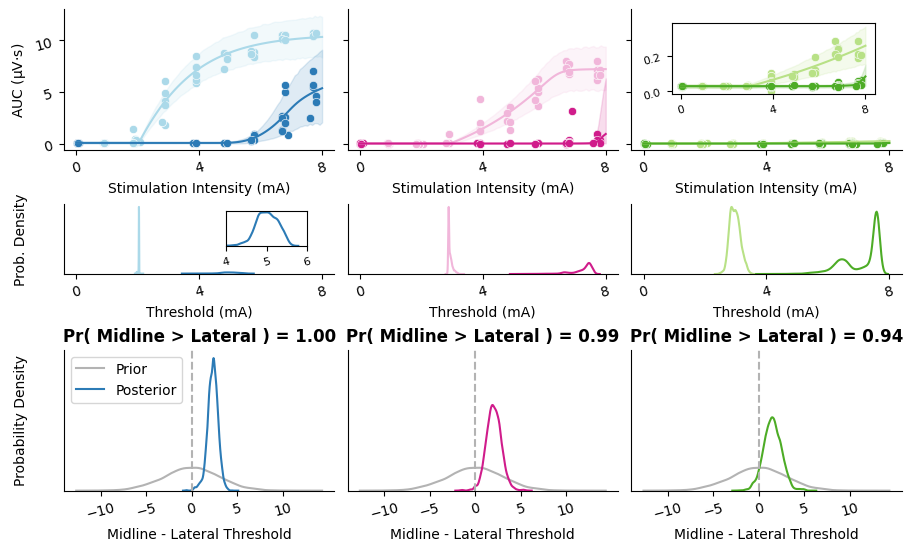

In [66]:
prior_color = (.7, .7, .7)

cmap = sns.color_palette("tab10")
axis_label_size = 10

nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 1.8 * nrows), squeeze=False, height_ratios=[1, .5, 1], constrained_layout=True)

# for i in range(nrows):
#     for j in range(ncols):
#         axes[i, j].set_visible(False)

for muscle_ind in range(model.n_response):
    for side in [0, 1]:
        c = (7, side)
        color = response_colors[side][muscle_ind]

        ind = df[model.combination_columns[::-1]].apply(tuple, axis=1).isin([c])
        temp_df = df[ind].reset_index(drop=True).copy()

        pred_ind = prediction_df[model.combination_columns[::-1]].apply(tuple, axis=1).isin([c])
        temp_pred_df = prediction_df[pred_ind].reset_index(drop=True).copy()

        temp_obs = obs[:, pred_ind, muscle_ind]
        temp_mu = mu[:, pred_ind, muscle_ind]
        temp_obs_hpdi = obs_hpdi[:, pred_ind, muscle_ind]

        ax = axes[0, muscle_ind]
        sns.scatterplot(x=temp_df[model.intensity], y=temp_df[model.response[muscle_ind]], ax=ax, color=color)
        sns.lineplot(x=temp_pred_df[model.intensity], y=temp_mu.mean(axis=0), color=color, ax=ax)
        ax.fill_between(
            temp_pred_df[model.intensity],
            temp_obs_hpdi[0, :],
            temp_obs_hpdi[1, :],
            color=color,
            alpha=.15
        )
        ax.sharex(axes[0, 0])
        ax.sharey(axes[0, 0])

        ax = axes[1, muscle_ind]
        sns.kdeplot(a[:, *c, muscle_ind], ax=ax, color=color)
        ax.sharex(axes[0, 0])
        if muscle_ind == 0:
            ax.set_ylim(bottom=-.5)

        if (side, muscle_ind) in [(1, 0)]:
            ins = ax.inset_axes([0.6,0.4,0.3,0.5])
            sns.kdeplot(a[:, *c, muscle_ind], ax=ins, color=color)
            ins.set_xlabel("")
            ins.set_ylabel("")
            ins.set_xlim(left=4, right=6)
            ins.tick_params(
                axis='both',
                which='both',
                left=False,
                bottom=True,
                right=False,
                top=False,
                labelleft=False,
                labelbottom=True,
                labelright=False,
                labeltop=False,
                labelrotation=15,
                labelsize=8
            )

    ax = axes[2, muscle_ind]
    samples = a_random_mean[:, 0, muscle_ind]
    d = dist.Normal(0, 3)
    prior = d.sample(model.rng_key, (10000, ))
    sns.kdeplot(prior, ax=ax, color=prior_color, label="Prior")
    sns.kdeplot(samples, ax=ax, color=response_colors[1][muscle_ind], label="Posterior")
    prob = (samples > 0).mean()
    ax.set_title(f"Pr( Midline > Lateral ) = {prob:.2f}", fontweight="bold")
    ax.sharex(axes[2, 0])
    ax.sharey(axes[2, 0])
    ax.axvline(x=0, color=prior_color, linestyle="--")

ax = axes[0, 2]
ins = ax.inset_axes([0.15,0.4,0.75 ,0.5])
for side in [0, 1]:
    c = (7, side)
    color = response_colors[side][muscle_ind]

    ind = df[model.combination_columns[::-1]].apply(tuple, axis=1).isin([c])
    temp_df = df[ind].reset_index(drop=True).copy()

    pred_ind = prediction_df[model.combination_columns[::-1]].apply(tuple, axis=1).isin([c])
    temp_pred_df = prediction_df[pred_ind].reset_index(drop=True).copy()

    temp_obs = obs[:, pred_ind, muscle_ind]
    temp_mu = mu[:, pred_ind, muscle_ind]
    temp_obs_hpdi = obs_hpdi[:, pred_ind, muscle_ind]

    sns.scatterplot(x=temp_df[model.intensity], y=temp_df[model.response[muscle_ind]], ax=ins, color=color)
    sns.lineplot(x=temp_pred_df[model.intensity], y=temp_mu.mean(axis=0), color=color, ax=ins)
    ins.fill_between(
        temp_pred_df[model.intensity],
        temp_obs_hpdi[0, :],
        temp_obs_hpdi[1, :],
        color=color,
        alpha=.15
    )
    ins.set_xlabel("")
    ins.set_ylabel("")
    ins.set_xticks([0, 4, 8])
    ins.set_yticks([0, 0.2])
    ins.tick_params(
        axis='both',
        which='both',
        left=True,
        bottom=True,
        right=False,
        top=False,
        labelleft=True,
        labelbottom=True,
        labelright=False,
        labeltop=False,
        labelrotation=15,
        labelsize=8
    )

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        sides = ['right', 'top']
        for side in sides:
            ax.spines[side].set_visible(False)
        ax.tick_params(
            axis='both',
            which='both',
            left=True,
            bottom=True,
            right=False,
            top=False,
            labelleft=False,
            labelbottom=True,
            labelright=False,
            labeltop=False,
            labelrotation=15
        )
        ax.set_xlabel("")
        ax.set_ylabel("")

for muscle_ind in range(model.n_response):
    for side in [0, 1]:
        ax = axes[0, muscle_ind]
        ax.set_xlabel("Stimulation Intensity (mA)", size=axis_label_size)

        ax = axes[1, muscle_ind]
        ax.set_xlabel("Threshold (mA)", size=axis_label_size)
        ax.tick_params(
            axis='both',
            which='both',
            left=False,
            labelleft=False,
            labelrotation=15
        )

        ax = axes[2, muscle_ind]
        ax.set_xlabel("Midline - Lateral Threshold", size=axis_label_size)
        ax.tick_params(
            axis='both',
            which='both',
            left=False,
            labelleft=False,
            labelrotation=15
        )

ax = axes[0, 0]
ax.tick_params(
    axis='both',
    which='both',
    labelleft=True,
    labelrotation=15
)
ax.set_ylabel("AUC (µV$\cdot$s)", size=axis_label_size)
ax.set_yticks([0, 5, 10])
ax.set_xticks([0, 4, 8])

ax = axes[1, 0]
ax.set_ylabel("Prob. Density", size=axis_label_size)

ax = axes[2, 0]
ax.tick_params(
    axis='both',
    which='both',
    left=True,
    labelleft=True,
    labelbottom=True,
    labelrotation=15
)
ax.tick_params(
    axis='both',
    which='both',
    left=False,
    labelleft=False,
    labelbottom=True,
    labelrotation=15
)
ax.set_ylabel("Probability Density", size=axis_label_size)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([0., 0.4, 0.8])
ax.legend(loc="upper left")

# axes[0, 0].set_title("Lateral", fontweight="bold", loc="left")
# axes[2, 0].set_title("Midline", fontweight="bold", loc="left")
# axes[4, 0].set_title("Result", fontweight="bold", loc="left")


# # """ Insets """
# # ax = axes[2, 2]
# # ins = ax.inset_axes([0.6,0.4,0.3,0.5])
# # sns.kdeplot(a[:, *c, 0], ax=ins, color=response_colors[j])
# # ins.set_xlabel("")
# # ins.set_ylabel("")
# # ins.set_xlim(left=1.98, right=2.1)
# # ins.set_ylim(bottom=-.03)



fig.align_xlabels()
fig.align_ylabels()
# [subfig.align_ylabels() for subfig in subfigs]

dest = os.path.join(model.build_dir, "midline-lateral-all-muscles-v2.svg")
fig.savefig(dest, dpi=600)

dest = os.path.join(model.build_dir, "midline-lateral-all-muscles-v2.png")
fig.savefig(dest, dpi=600)

In [16]:
dest

'/home/vishu/repos/hbmep-paper/reports/paper/figures/intraoperative/midline-lateral/all-muscles/midline-lateral-all-muscles-v2.png'